In [1]:
import os
import pathlib
import subprocess
from matplotlib import pyplot as plt
from tqdm.contrib import itertools
import numpy as np
from stl import mesh
from mpl_toolkits import mplot3d

  0%|          | 0/72000 [00:00<?, ?it/s]

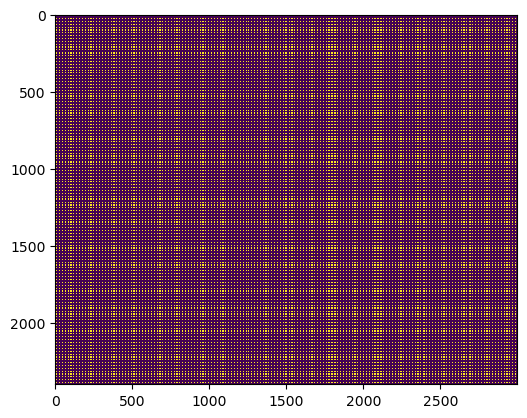

In [4]:
# Texture dimensions
HEIGHT_MM = 80
WIDTH_MM = 100
DEPTH_MM = 3

N_STIM_HEIGHT = 80 * 3
N_STIM_WIDTH = 100 * 3

PPMM = 30
DIAMETER_UM = 100
DIAMETER_P = DIAMETER_UM / 1000 * PPMM
STD_UM = 1  #STD diameter
STD_P = STD_UM / 1000 * PPMM

## Pick diameter of the dot from a gaussian distribution
diameters = np.random.normal(DIAMETER_P, STD_P, (N_STIM_HEIGHT, N_STIM_WIDTH))
# diameters = DIAMETER_P * np.ones((N_STIM_HEIGHT, N_STIM_WIDTH))

max_diam = int(np.max(diameters))

spacing_x = np.linspace(0, HEIGHT_MM * PPMM, N_STIM_HEIGHT + 2, dtype=np.uint64)[1:-1]
spacing_y = np.linspace(0, WIDTH_MM * PPMM, N_STIM_WIDTH + 2, dtype=np.uint64)[1:-1]

data = int(0.8 * DEPTH_MM * PPMM) * np.ones(
    (HEIGHT_MM * PPMM, WIDTH_MM * PPMM), dtype=np.uint64
)

for i, j in itertools.product(range(diameters.shape[0]), range(diameters.shape[1])):
    x, y = (spacing_x[i], spacing_y[j])
    x, y = int(x), int(y)
    data[x, y] = int(DEPTH_MM * PPMM)

    angles = np.linspace(0, np.pi / 2, 100)
    for k in angles:
        # for l in np.linspace(0, diameters[i, j], max_diam):
        #     xc, yc = (x + np.sin(k) * l, y + np.cos(k) * l)
        #     data[int(xc), int(yc)] = 255
        xc, yc = (np.sin(k) * diameters[i, j], np.cos(k) * diameters[i, j])
        xc, yc = int(xc), int(yc)
        data[x : x + xc, y : y + yc] = int(DEPTH_MM * PPMM)
        data[x - xc : x, y : y + yc] = int(DEPTH_MM * PPMM)
        data[x - xc : x, y - yc : y] = int(DEPTH_MM * PPMM)
        data[x : x + xc, y - yc : y] = int(DEPTH_MM * PPMM)


plt.imshow(data, interpolation="nearest")
plt.show()


In [5]:

height_div_width = DEPTH_MM / WIDTH_MM

im_array = data  # .transpose((1, 0, 2))
im_array = np.rot90(im_array, -1, (0, 1))
mesh_size = [im_array.shape[0], im_array.shape[1]]
mesh_max = np.max(im_array)
if len(im_array.shape) == 3:
    scaled_mesh = mesh_size[0] * float(height_div_width) * im_array[:, :, 0] / mesh_max
else:
    scaled_mesh = mesh_size[0] * float(height_div_width) * im_array / mesh_max

mesh_shape = mesh.Mesh(
    np.zeros((mesh_size[0] - 1) * (mesh_size[1] - 1) * 2, dtype=mesh.Mesh.dtype)
)


for i, j in itertools.product(range(0, mesh_size[0] - 1), range(0, mesh_size[1] - 1)):
    mesh_num = i * (mesh_size[1] - 1) + j
    mesh_shape.vectors[2 * mesh_num][2] = [i, j, scaled_mesh[i, j]]
    mesh_shape.vectors[2 * mesh_num][1] = [i, j + 1, scaled_mesh[i, j + 1]]
    mesh_shape.vectors[2 * mesh_num][0] = [i + 1, j, scaled_mesh[i + 1, j]]
    mesh_shape.vectors[2 * mesh_num + 1][0] = [i + 1, j + 1, scaled_mesh[i + 1, j + 1]]
    mesh_shape.vectors[2 * mesh_num + 1][1] = [i, j + 1, scaled_mesh[i, j + 1]]
    mesh_shape.vectors[2 * mesh_num + 1][2] = [i + 1, j, scaled_mesh[i + 1, j]]

# build base
vertices = np.array(
    [
        [0, 0, 0],
        [mesh_size[0] - 1, 0, 0],
        [mesh_size[0] - 1, mesh_size[1] - 1, 0],
        [0, mesh_size[1] - 1, 0],
        [0, 0, scaled_mesh[0, 0]],
        [mesh_size[0] - 1, 0, scaled_mesh[0, 0]],
        [mesh_size[0] - 1, mesh_size[1] - 1, scaled_mesh[0, 0]],
        [0, mesh_size[1] - 1, scaled_mesh[0, 0]],
    ]
)
faces = np.array(
    [
        [0, 3, 1],
        [1, 3, 2],
        [0, 4, 7],
        [0, 7, 3],
        [4, 5, 6],
        [4, 6, 7],
        [5, 1, 2],
        [5, 2, 6],
        [2, 3, 6],
        [3, 7, 6],
        [0, 1, 5],
        [0, 5, 4],
    ]
)

for i, f in enumerate(faces):
    for j in range(3):
        mesh_shape.vectors[2 * (mesh_size[0] + mesh_size[1]) + i][j] = vertices[f[j], :]

dirname = pathlib.Path("__file__").resolve().parent
print(dirname)

# save stl file
mesh_shape.save(dirname / "test.stl")

##subprocess.run(["f3d", "test.stl"], stdin=subprocess.PIPE, stdout=subprocess.PIPE)
#print("done")

  0%|          | 0/7194601 [00:00<?, ?it/s]

C:\Users\fradin\Downloads\dotted_texture_bonnes
